In [44]:
from google.colab import drive
drive.mount('/content/gdrive/')
path = "/content/gdrive/My Drive/Colab Notebooks"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [45]:
import re, os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [46]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib

In [47]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

from fastai.tabular import *
from fastai.tabular.all import *
from fastai.tabular.data import *
from fastai.tabular.learner import *

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [90]:
data = pd.read_csv(path+"/data_shuf.csv")
alist = data.columns.to_list()
alist

['city_id',
 'land_cover',
 'pop2012',
 'X',
 'Y',
 'road_len',
 'night2012',
 'cen_dist',
 'dem',
 'city_pop_total']

In [91]:
data.describe()

,city_id,land_cover,pop2012,X,Y,road_len,night2012,cen_dist,dem,city_pop_total
count,433774.000000,433774.000000,433774.000000,433774.000000,433774.000000,433774.000000,433774.000000,433774.000000,433774.000000,433774.000000
mean,43.818316,6.906518,0.008004,0.502616,0.501277,0.071480,0.020648,0.214999,0.094664,0.192048
std,22.376779,1.857292,0.032205,0.230683,0.231005,0.093311,0.042011,0.142153,0.111697,0.301218
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,7.000000,0.000000,0.322222,0.319149,0.000000,0.001736,0.115120,0.018639,0.021847
50%,44.000000,7.000000,0.000061,0.500000,0.500000,0.046930,0.004673,0.182038,0.054225,0.036372
75%,65.000000,8.000000,0.001265,0.684982,0.683673,0.104343,0.017724,0.279313,0.126239,0.141055
max,83.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
cat_names = alist[0:2]
cont_names = alist[3:]
y_names = alist[2]
procs = [Categorify,]

In [52]:
splits = RandomSplitter(valid_pct=0.2)(range_of(data))

In [53]:
cont,cat = cont_cat_split(data, 1, dep_var=y_names)
to = TabularPandas(data, procs, cat, cont, y_names=y_names, splits=splits)

In [54]:
len(to.xs),len(to.train),len(to.valid)

(433774, 347020, 86754)

In [55]:
xs, y = to.xs,to.y
train_xs,train_y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

## Decision Tree

In [56]:
dt = DecisionTreeRegressor(max_leaf_nodes=10, min_samples_leaf=25)
dt.fit(train_xs, train_y);

In [57]:
dt.get_n_leaves(), len(train_xs)

(10, 347020)

In [58]:
def rmse(y,y_pred): return mean_squared_error(y,y_pred,squared=False)

In [59]:
train_rmse = rmse(dt.predict(train_xs), train_y)
valid_rmse = rmse(dt.predict(valid_xs), valid_y)

In [60]:
std = data.describe().to_dict()['pop2012']['std']
R2 = 1 - ( valid_rmse / std ) ** 2
train_rmse, valid_rmse, R2

(0.018650752307255512, 0.01882548123846888, 0.6582954168705879)

## Random Forest

In [94]:
n_estimators = 500
max_samples = 200_000
max_features = 0.5
min_samples_leaf = 5

In [95]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
    max_samples=max_samples, max_features=max_features,
    min_samples_leaf=min_samples_leaf, oob_score=True)

In [ ]:
import time
start = time.time()
m = rf.fit(train_xs, train_y);
end = time.time()
print("Time:", end-start)

Time: 270.16565704345703


In [98]:
train_rmse = rmse(m.predict(train_xs), train_y)
valid_rmse = rmse(m.predict(valid_xs), valid_y)

In [99]:
std = data.describe().to_dict()['pop2012']['std']
R2 = 1 - ( valid_rmse / std ) ** 2
train_rmse, valid_rmse, R2

(0.011539238245678657, 0.014187205833462179, 0.8059326974829601)

In [100]:
train_preds = np.stack([t.predict(train_xs) for t in m.estimators_])
valid_preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
train_preds.shape, valid_preds.shape

((500, 347020), (500, 86754))

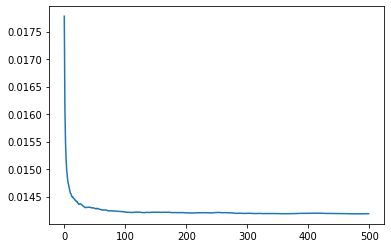

In [110]:
plt.plot([rmse(valid_preds[:i+1].mean(0), valid_y) for i in range(0,500)]);

In [102]:
# Save the model
joblib_file = "forest.pkl"
joblib.dump(m, path+r"/"+joblib_file)
print('Model Saved!')

Model Saved!


## Now Prediction!

In [103]:
# Load from file
joblib_file = "forest.pkl"
joblib_model = joblib.load(path+r"/"+joblib_file)

In [104]:
# predict with the model
data = pd.read_csv(path+"/data_new.csv")
alist = data.columns.to_list()
cat_names = alist[1]
cont_names = alist[3:]
y_names = alist[2]
procs = [Categorify,]
cont,cat = cont_cat_split(data, 1, dep_var=y_names)
to = TabularPandas(data, procs, cat, cont, y_names=y_names, splits=splits)
xs, y = to.xs, to.y

In [105]:
preds = joblib_model.predict(xs)

In [106]:
# Transform to the pre-normalized state
maxi = 57586.267532
preds = preds * maxi

In [107]:
# Copy in the csv
data = pd.read_csv(path+r"/data.csv")
data['pop_pred'] = preds

In [109]:
data.to_csv(path+r"/data_preds.csv",index=False)
print('File Exported!')

File Exported!
